# HOMEWORK 3 - KAGGLE BIRD CLASSIFICATION CHALLENGE

In [1]:
import argparse
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm
import zipfile
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image
import torch
from torch.optim.lr_scheduler import StepLR

from google.colab import drive
drive.mount("/content/drive")

#Parameter initialisation
path_data ="/content/drive/MyDrive/RecVis/HW3/bird_dataset"
batch_size = 64
epochs = 20
lr = 1e-4
momentum = 0.5
seed = 1
log_interval = 5
img_size = 256
early_stop_count = 4

use_cuda = torch.cuda.is_available()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### DATA TRANSFORMATION
We first apply a set of transformations to the data. 
- we resize the images
- we transform the images into tensors
- we normalize the tensors


In [2]:
#Data transformation on the train set
data_transforms_train = transforms.Compose([
    transforms.RandomAffine(15),
    transforms.ColorJitter(brightness=0.2,saturation=0.2),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(inplace=True)
      
])

#Data transformation on the valid set
data_transforms_valid = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

#Data transformation on the test set
data_transforms_test = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

### We load and initialize the data

In [3]:
# Data initialization and loading
train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path_data + '/train_images',
                         transform=data_transforms_train),
    batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(path_data + '/val_images',
                         transform=data_transforms_valid),
    batch_size=batch_size, shuffle=False, num_workers=1)

train_data = datasets.ImageFolder(path_data + '/train_images')
print("The different types of bird that we have : \n")
labels = list(train_data.class_to_idx.keys())
for i in range(len(labels)):
    print(i+1,labels[i])

The different types of bird that we have : 

1 004.Groove_billed_Ani
2 009.Brewer_Blackbird
3 010.Red_winged_Blackbird
4 011.Rusty_Blackbird
5 012.Yellow_headed_Blackbird
6 013.Bobolink
7 014.Indigo_Bunting
8 015.Lazuli_Bunting
9 016.Painted_Bunting
10 019.Gray_Catbird
11 020.Yellow_breasted_Chat
12 021.Eastern_Towhee
13 023.Brandt_Cormorant
14 026.Bronzed_Cowbird
15 028.Brown_Creeper
16 029.American_Crow
17 030.Fish_Crow
18 031.Black_billed_Cuckoo
19 033.Yellow_billed_Cuckoo
20 034.Gray_crowned_Rosy_Finch


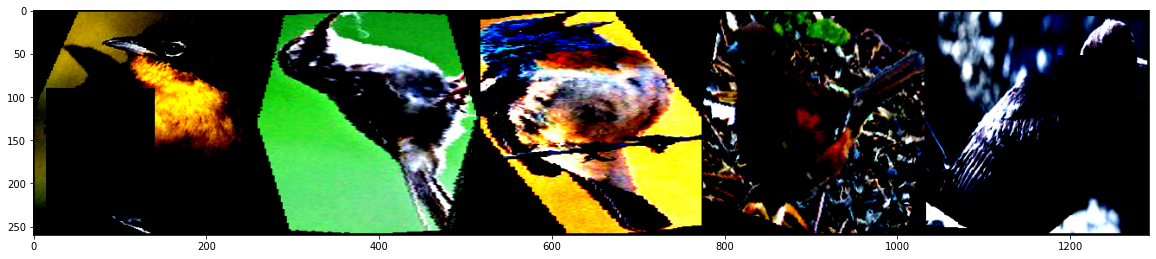

020.Yellow_breasted_Chat     028.Brown_Creeper     015.Lazuli_Bunting     021.Eastern_Towhee     023.Brandt_Cormorant


In [4]:
#Let's display 5 of those images :
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels_index = dataiter.next()
# show images
plt.figure(figsize=(20,25))
imshow(torchvision.utils.make_grid(images[0:5]))

# print labels
print('     '.join('%16s' % str(labels[int(labels_index[j])]) for j in range(5)))

### We create our network

The first network is a 4 layer neural network. 
We then create a ResNet50, a ResNet101 and a ResNet152 using transfer learning. 

In [5]:
#Model of the neural network
nclasses = 20 #Number of types of bird in the end

#The original model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, nclasses)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

#my model

class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()
        #pre-trained model
        self.resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')
        layers = list(self.resnet.children())[:-2]
        self.features = nn.Sequential(*layers)  
        
        #We replace the last_layer
        # Replace last layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc =nn.Sequential(
        nn.Linear(num_ftrs,64),
        nn.Tanh(),
        nn.Dropout(0.6),
        nn.Linear(64,nclasses))
       
    def freeze(self):
        # To freeze the parameters up to the last layer
        for param in self.features.parameters():
            param.require_grad = False

    def unfreeze(self):
        # we unfreeze all layers
        for param in self.features.parameters():
            param.require_grad = True
    
    def forward(self, x):
        return self.resnet(x)
    
class ResNet101(nn.Module):
    def __init__(self):
        super(ResNet101, self).__init__()
        #the pretrained ResNet101 model
        self.network = models.resnet101(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, nclasses)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True
            
    def forward(self,x):
        return torch.sigmoid(self.network(x))

class ResNet152(nn.Module):
    def __init__(self):
        super(ResNet152, self).__init__()
        #the pretrained ResNet101 model
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, nclasses)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True
            
    def forward(self,x):
        return torch.sigmoid(self.network(x))

In [6]:
# Neural network and optimizer
# We define neural net in model.py so that it can be reused by the evaluate.py script
import torchvision.models as models
model = ResNet50()
if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')

hyperparam = {'lr':1e-4, 'w_decay':1e-5, 'step_size' : 20 , 'gamma' : 0.1} 
optimizer = optim.Adam(params=model.parameters(), lr=hyperparam['lr'], weight_decay=hyperparam['w_decay'])
scheduler = StepLR(optimizer, step_size=hyperparam['step_size'], gamma=hyperparam['gamma']) 
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(output, target)
        train_loss += loss.data.item()

        loss.backward()
        optimizer.step()
        
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    return (train_loss /len(train_loader.dataset), 100. * correct / len(train_loader.dataset))

def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        # sum up batch loss
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    validation_acc = 100. * correct / len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),validation_acc))
    
    return validation_loss , validation_acc

Using GPU


In [7]:
val_acc_list =[]
val_loss_list = []
train_acc_list =[]
train_loss_list = []

#First training with froze parameters
model.freeze()
print("Training with frozen parameters")
for epoch in range(1, epochs + 1):
    train_loss,train_acc = train(epoch)
    val_loss , val_acc = validation()

    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    scheduler.step()

Training with frozen parameters
Train Epoch: 1 [0/1096 (0%)]	Loss: 2.992731
Train Epoch: 1 [320/1096 (28%)]	Loss: 2.990395
Train Epoch: 1 [640/1096 (56%)]	Loss: 2.977109
Train Epoch: 1 [960/1096 (83%)]	Loss: 2.927592

Validation set: Average loss: 0.0563, Accuracy: 27/103 (26%)
Train Epoch: 2 [0/1096 (0%)]	Loss: 2.889170
Train Epoch: 2 [320/1096 (28%)]	Loss: 2.847400
Train Epoch: 2 [640/1096 (56%)]	Loss: 2.760484
Train Epoch: 2 [960/1096 (83%)]	Loss: 2.626937

Validation set: Average loss: 0.0496, Accuracy: 56/103 (54%)
Train Epoch: 3 [0/1096 (0%)]	Loss: 2.593101
Train Epoch: 3 [320/1096 (28%)]	Loss: 2.454102
Train Epoch: 3 [640/1096 (56%)]	Loss: 2.362539
Train Epoch: 3 [960/1096 (83%)]	Loss: 2.207149

Validation set: Average loss: 0.0357, Accuracy: 74/103 (72%)
Train Epoch: 4 [0/1096 (0%)]	Loss: 1.998906
Train Epoch: 4 [320/1096 (28%)]	Loss: 1.970150
Train Epoch: 4 [640/1096 (56%)]	Loss: 1.760556
Train Epoch: 4 [960/1096 (83%)]	Loss: 1.784590

Validation set: Average loss: 0.0268, Acc

Now we train on unfrozen parameters with an early stopping method

In [8]:
#Second we train we unfrozen parameters
best_loss = 1000
regress_count = 0

model.unfreeze()
print("Training with unfrozen parameters")
for epoch in range(1, epochs + 1):
    train_loss , train_acc = train(epoch)
    val_loss , val_acc = validation()
    
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    scheduler.step()

    # Early stopping
    if val_loss > best_loss:

      regress_count += 1
      print('Number of concecutive times the model regresses', regress_count)

      if regress_count >= early_stop_count:
        print('Stopped because of early stopping')
        break

    else:
      regress_count = 0
    
    best_loss = val_loss

    model_file = '/content/drive/MyDrive/RecVis/HW3/model' + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

Training with unfrozen parameters
Train Epoch: 1 [0/1096 (0%)]	Loss: 0.319279
Train Epoch: 1 [320/1096 (28%)]	Loss: 0.344305
Train Epoch: 1 [640/1096 (56%)]	Loss: 0.287855
Train Epoch: 1 [960/1096 (83%)]	Loss: 0.455146

Validation set: Average loss: 0.0095, Accuracy: 94/103 (91%)
Saved model to /content/drive/MyDrive/RecVis/HW3/model/model_1.pth. You can run `python evaluate.py --model /content/drive/MyDrive/RecVis/HW3/model/model_1.pth` to generate the Kaggle formatted csv file

Train Epoch: 2 [0/1096 (0%)]	Loss: 0.330892
Train Epoch: 2 [320/1096 (28%)]	Loss: 0.376902
Train Epoch: 2 [640/1096 (56%)]	Loss: 0.374439
Train Epoch: 2 [960/1096 (83%)]	Loss: 0.308556

Validation set: Average loss: 0.0092, Accuracy: 95/103 (92%)
Saved model to /content/drive/MyDrive/RecVis/HW3/model/model_2.pth. You can run `python evaluate.py --model /content/drive/MyDrive/RecVis/HW3/model/model_2.pth` to generate the Kaggle formatted csv file

Train Epoch: 3 [0/1096 (0%)]	Loss: 0.408644
Train Epoch: 3 [320/

### EVALUATION

We now evaluate our model on the test data in order to submit our predictions on Kaggle

In [9]:
path_data ="/content/drive/MyDrive/RecVis/HW3/bird_dataset"
outfile = '/content/drive/MyDrive/RecVis/HW3/experiment/kaggle.csv'

state_dict = torch.load('/content/drive/MyDrive/RecVis/HW3/model/model_17.pth')
model = ResNet50()
model.load_state_dict(state_dict)
model.eval()

if use_cuda:
    print('Using GPU')
    model.cuda()
else:
    print('Using CPU')

test_dir = path_data + '/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = data_transforms_test(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        if use_cuda:
            data = data.cuda()
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')

Using GPU


100%|██████████| 517/517 [00:12<00:00, 42.11it/s]

Succesfully wrote /content/drive/MyDrive/RecVis/HW3/experiment/kaggle.csv, you can upload this file to the kaggle competition website
